In [1]:
# Author: A. Wenteler

In [15]:
import pandas as pd
import biorosetta as br 
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_sizes

formatter = mpl_sizes.get_format("NeurIPS") # options: ICLR, ICML, NeurIPS, InfThesis

In [16]:
#perts = ['GLB1L2', 'GLB1L2', 'SET', 'SPI1',]
perts = ['AHR', 'CEBPE', 'IKZF3', 'CEBPA']
models = ['mean', 'raw_expression', 'scgpt', 'scbert', 'scfoundation', 'uce', 'geneformer']

In [17]:
# Load the data
base = '../../data/splits/perturb/norman_1/'
base_path = f'{base}pert_effects/' 

In [18]:
data = {model: {pert: {} for pert in perts} for model in models}

for model in models:
    for pert in perts:
        try:
            pred_path = f'{base_path}{pert}/pert_effect_pred_{model}.pkl'
            target_path = f'{base_path}{pert}/pert_effect_target_{model}.pkl'
            data[model][pert]['pred'] = pd.read_pickle(pred_path).numpy()
            data[model][pert]['target'] = pd.read_pickle(target_path).numpy()
        except FileNotFoundError:
            print(f"Data not found for {model} - {pert}")

Data not found for mean - AHR
Data not found for mean - CEBPE
Data not found for mean - IKZF3
Data not found for mean - CEBPA
Data not found for scgpt - AHR
Data not found for scgpt - CEBPE
Data not found for scgpt - IKZF3
Data not found for scgpt - CEBPA
Data not found for scbert - AHR
Data not found for scbert - CEBPE
Data not found for scbert - IKZF3
Data not found for scbert - CEBPA
Data not found for scfoundation - AHR
Data not found for scfoundation - CEBPE
Data not found for scfoundation - IKZF3
Data not found for scfoundation - CEBPA
Data not found for uce - AHR
Data not found for uce - CEBPE
Data not found for uce - IKZF3
Data not found for uce - CEBPA
Data not found for geneformer - AHR
Data not found for geneformer - CEBPE
Data not found for geneformer - IKZF3
Data not found for geneformer - CEBPA


In [19]:
deg_dict = pd.read_pickle(f'{base}de_test/deg_pert_dict.pkl')

In [20]:
idmap = br.IDMapper('all') 
deg_dict_symb = {}
for k, v in deg_dict.items():
    converted = idmap.convert(v, 'ensg', 'symb')
    deg_dict_symb[k] = [symb if symb != 'N/A' else ensg for ensg, symb in zip(v, converted)]

- Loading lookup tables from cache (use function EnsemblBiomartMapper.download_data() to force new download)
- Loading lookup tables from cache (use function HGNCBiomartMapper.download_data() to force new download)


In [21]:
model_names = {
    'mean': 'Mean baseline',
    'raw_expression': 'MLP baseline',
    'scgpt': 'scGPT',
    'scbert': 'scBERT',
    'scfoundation': 'scFoundation',
    'uce': 'UCE',
    'geneformer': 'Geneformer'
}
model_colors = pd.read_pickle(f'model_colors.pkl')
model_colors_dict = {
    'Mean baseline': model_colors['Mean baseline'],
    'MLP baseline': model_colors['MLP baseline'],
    'scBERT': model_colors['scBERT'],
    'UCE': model_colors['UCE'],
    'Geneformer': model_colors['Geneformer'],
    'scGPT': model_colors['scGPT'],
    'scFoundation': model_colors['scFoundation']
}
model_colors_dict

{'Mean baseline': (0.03529411764705882,
  0.596078431372549,
  0.611764705882353,
  1.0),
 'MLP baseline': (0.8980392156862745,
  0.11764705882352941,
  0.19607843137254902,
  1.0),
 'scBERT': (0.6941176470588235, 0.792156862745098, 0.0196078431372549, 1.0),
 'UCE': (0.24705882352941178, 0.39215686274509803, 0.807843137254902, 1.0),
 'Geneformer': (0.49411764705882355,
  0.16862745098039217,
  0.5568627450980392,
  1.0),
 'scGPT': (0.9921568627450981, 0.6588235294117647, 0.0196078431372549, 1.0),
 'scFoundation': (0.4666666666666667,
  0.596078431372549,
  0.08235294117647059,
  1.0)}

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_swarm_plots(data, deg_dict_symb, variance_threshold=0.01, effect_threshold=0.1):
    for pert in data['raw_expression']:
        # Get the differentially expressed genes for this perturbation
        deg_genes = deg_dict_symb.get(pert, [])

        # Extract the target gene expression data
        target = data['raw_expression'][pert]['target']

        # Create a DataFrame for the target
        df_target = pd.DataFrame(target, columns=deg_genes)

        # Calculate variance and absolute mean effect for each gene
        gene_variances = df_target.var()
        gene_effects = df_target.abs().mean()

        # Filter genes based on variance and effect size
        genes_to_keep = (gene_variances > variance_threshold) & (gene_effects > effect_threshold)
        df_target_filtered = df_target.loc[:, genes_to_keep]

        # If no genes pass the filter, skip this plot
        if df_target_filtered.empty:
            print(f"No genes pass the filter for {pert}")
            continue

        # Calculate the absolute mean effect for each remaining gene
        gene_effects = df_target_filtered.abs().mean().sort_values(ascending=False)

        # Order the genes based on absolute effect size
        ordered_genes = gene_effects.index.tolist()

        # Reorder the DataFrame columns
        df_target_filtered = df_target_filtered[ordered_genes]

        # Calculate the mean of the target gene expression data
        target_means = df_target_filtered.mean()

        # Create a DataFrame to store mean expression for each model
        model_means = pd.DataFrame({'Gene': ordered_genes, 'Target': target_means})

        # Process data for each model
        for model in data:
            pred = data[model][pert]['pred']
            df_model = pd.DataFrame(pred, columns=deg_genes)
            df_model_filtered = df_model[ordered_genes]
            model_means[model] = df_model_filtered.mean()

        # Melt the DataFrame for seaborn
        model_means_melted = model_means.melt(id_vars='Gene', var_name='Model', value_name='Expression')

        # Create the plot
        plt.figure(figsize=(16, 8), dpi=300)

        # Plot the target means as dashed lines per gene
        for i, gene in enumerate(ordered_genes):
            plt.plot([i - 0.4, i + 0.4], [target_means[gene]] * 2, 'k--', label='Target mean' if i == 0 else "")

        # Use seaborn's swarmplot to plot the model means
        model_means_melted = model_means_melted[model_means_melted['Model'] != 'Target']
        model_means_melted['Model'] = model_means_melted['Model'].map(model_names)
        palette = {model: model_colors_dict[model] for model in model_means_melted['Model'].unique()}
        
        sns.swarmplot(data=model_means_melted, x='Gene', y='Expression', hue='Model', dodge=True, size=8, palette=palette)

        # Customize the plot
        plt.xticks(range(len(ordered_genes)), ordered_genes, rotation=45, ha='right')
        plt.xlabel('Differentially expressed genes')
        plt.ylabel('Perturbation effect (LogFC)')
        plt.legend(loc='upper right')
        
        # Disable the legend
        # plt.legend([],[], frameon=False)

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.savefig(f"paper_figs/{pert}_swarmplot.pdf")
        plt.show()

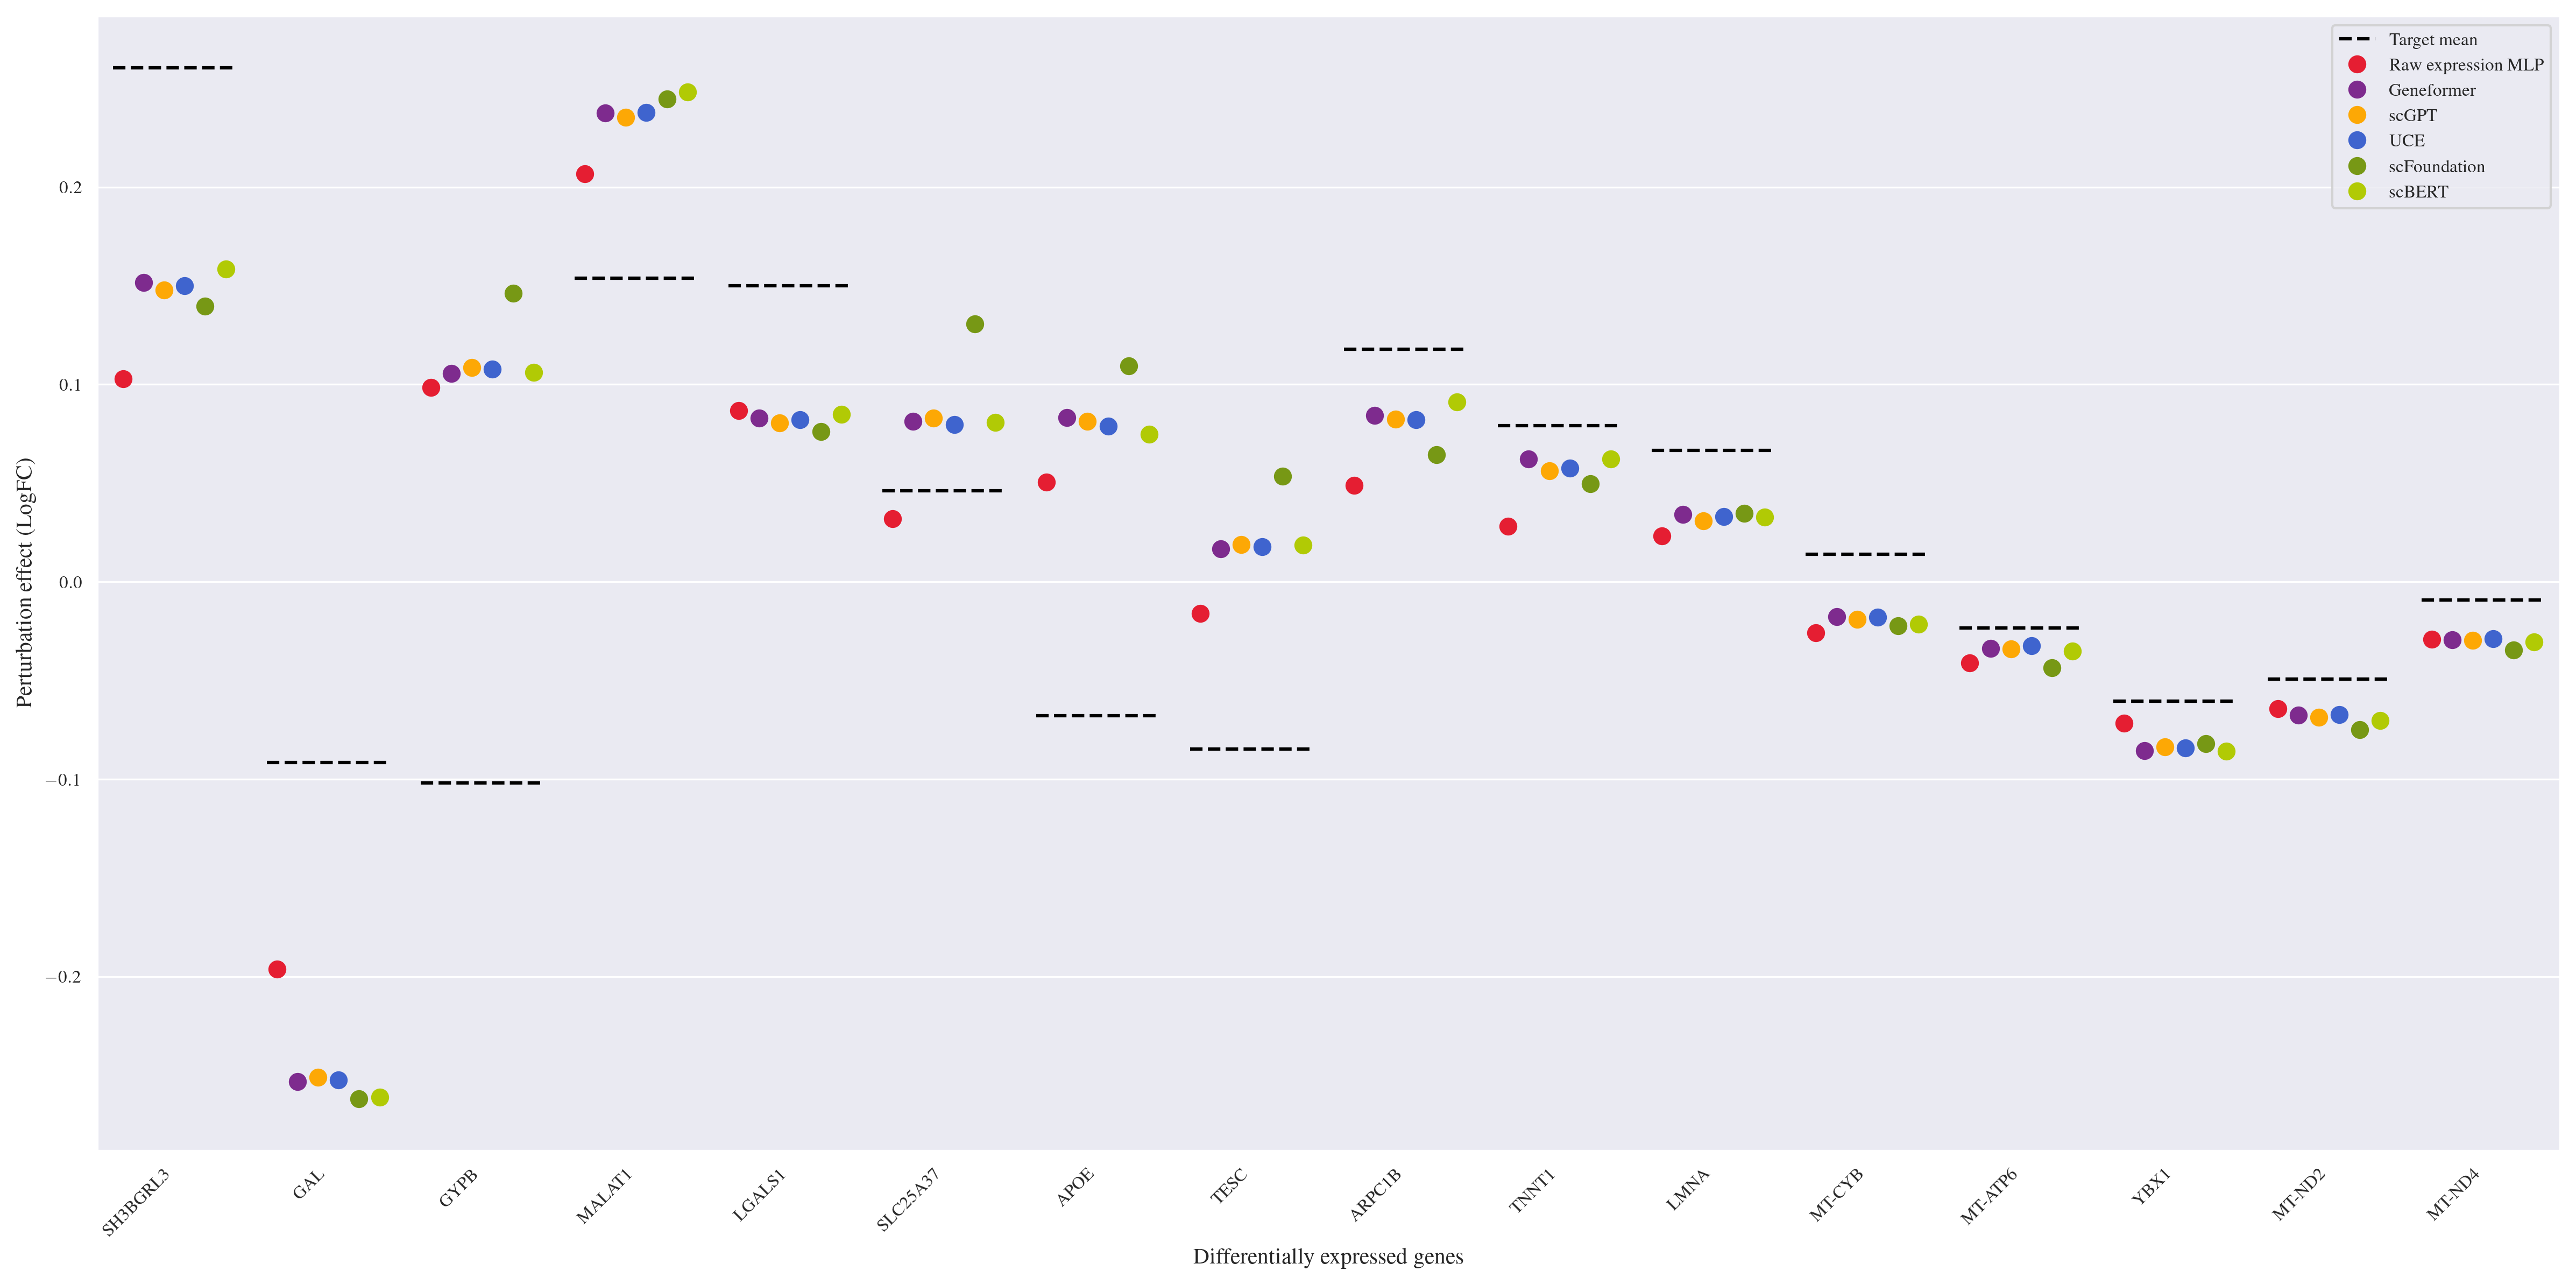

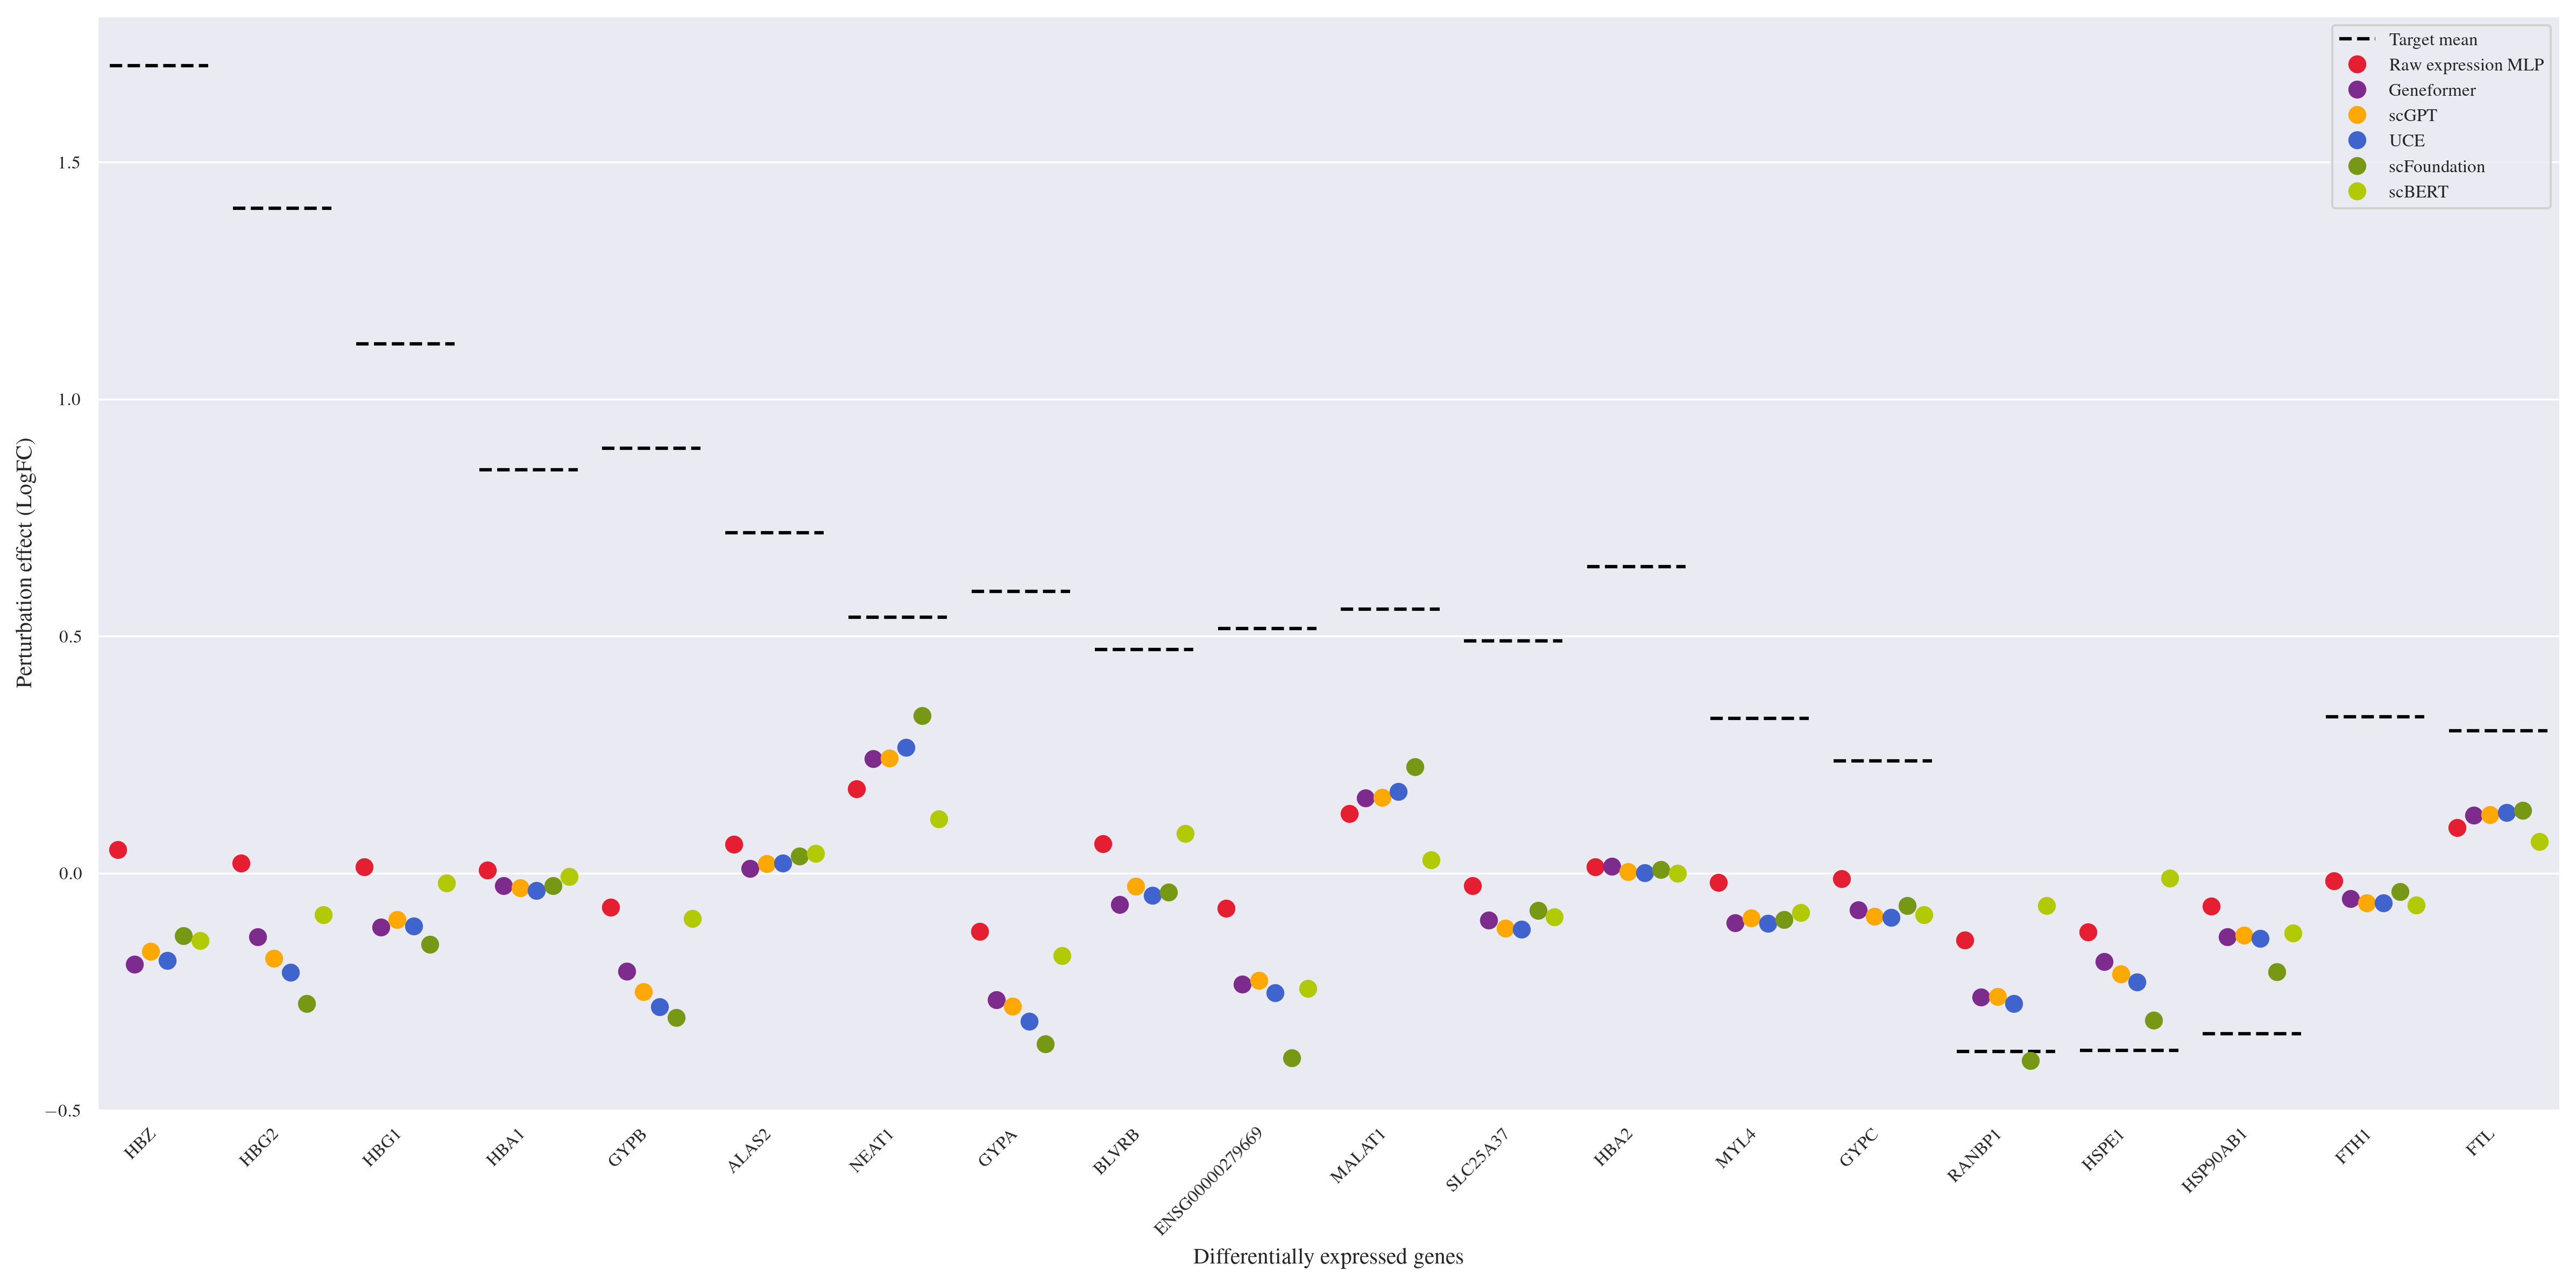

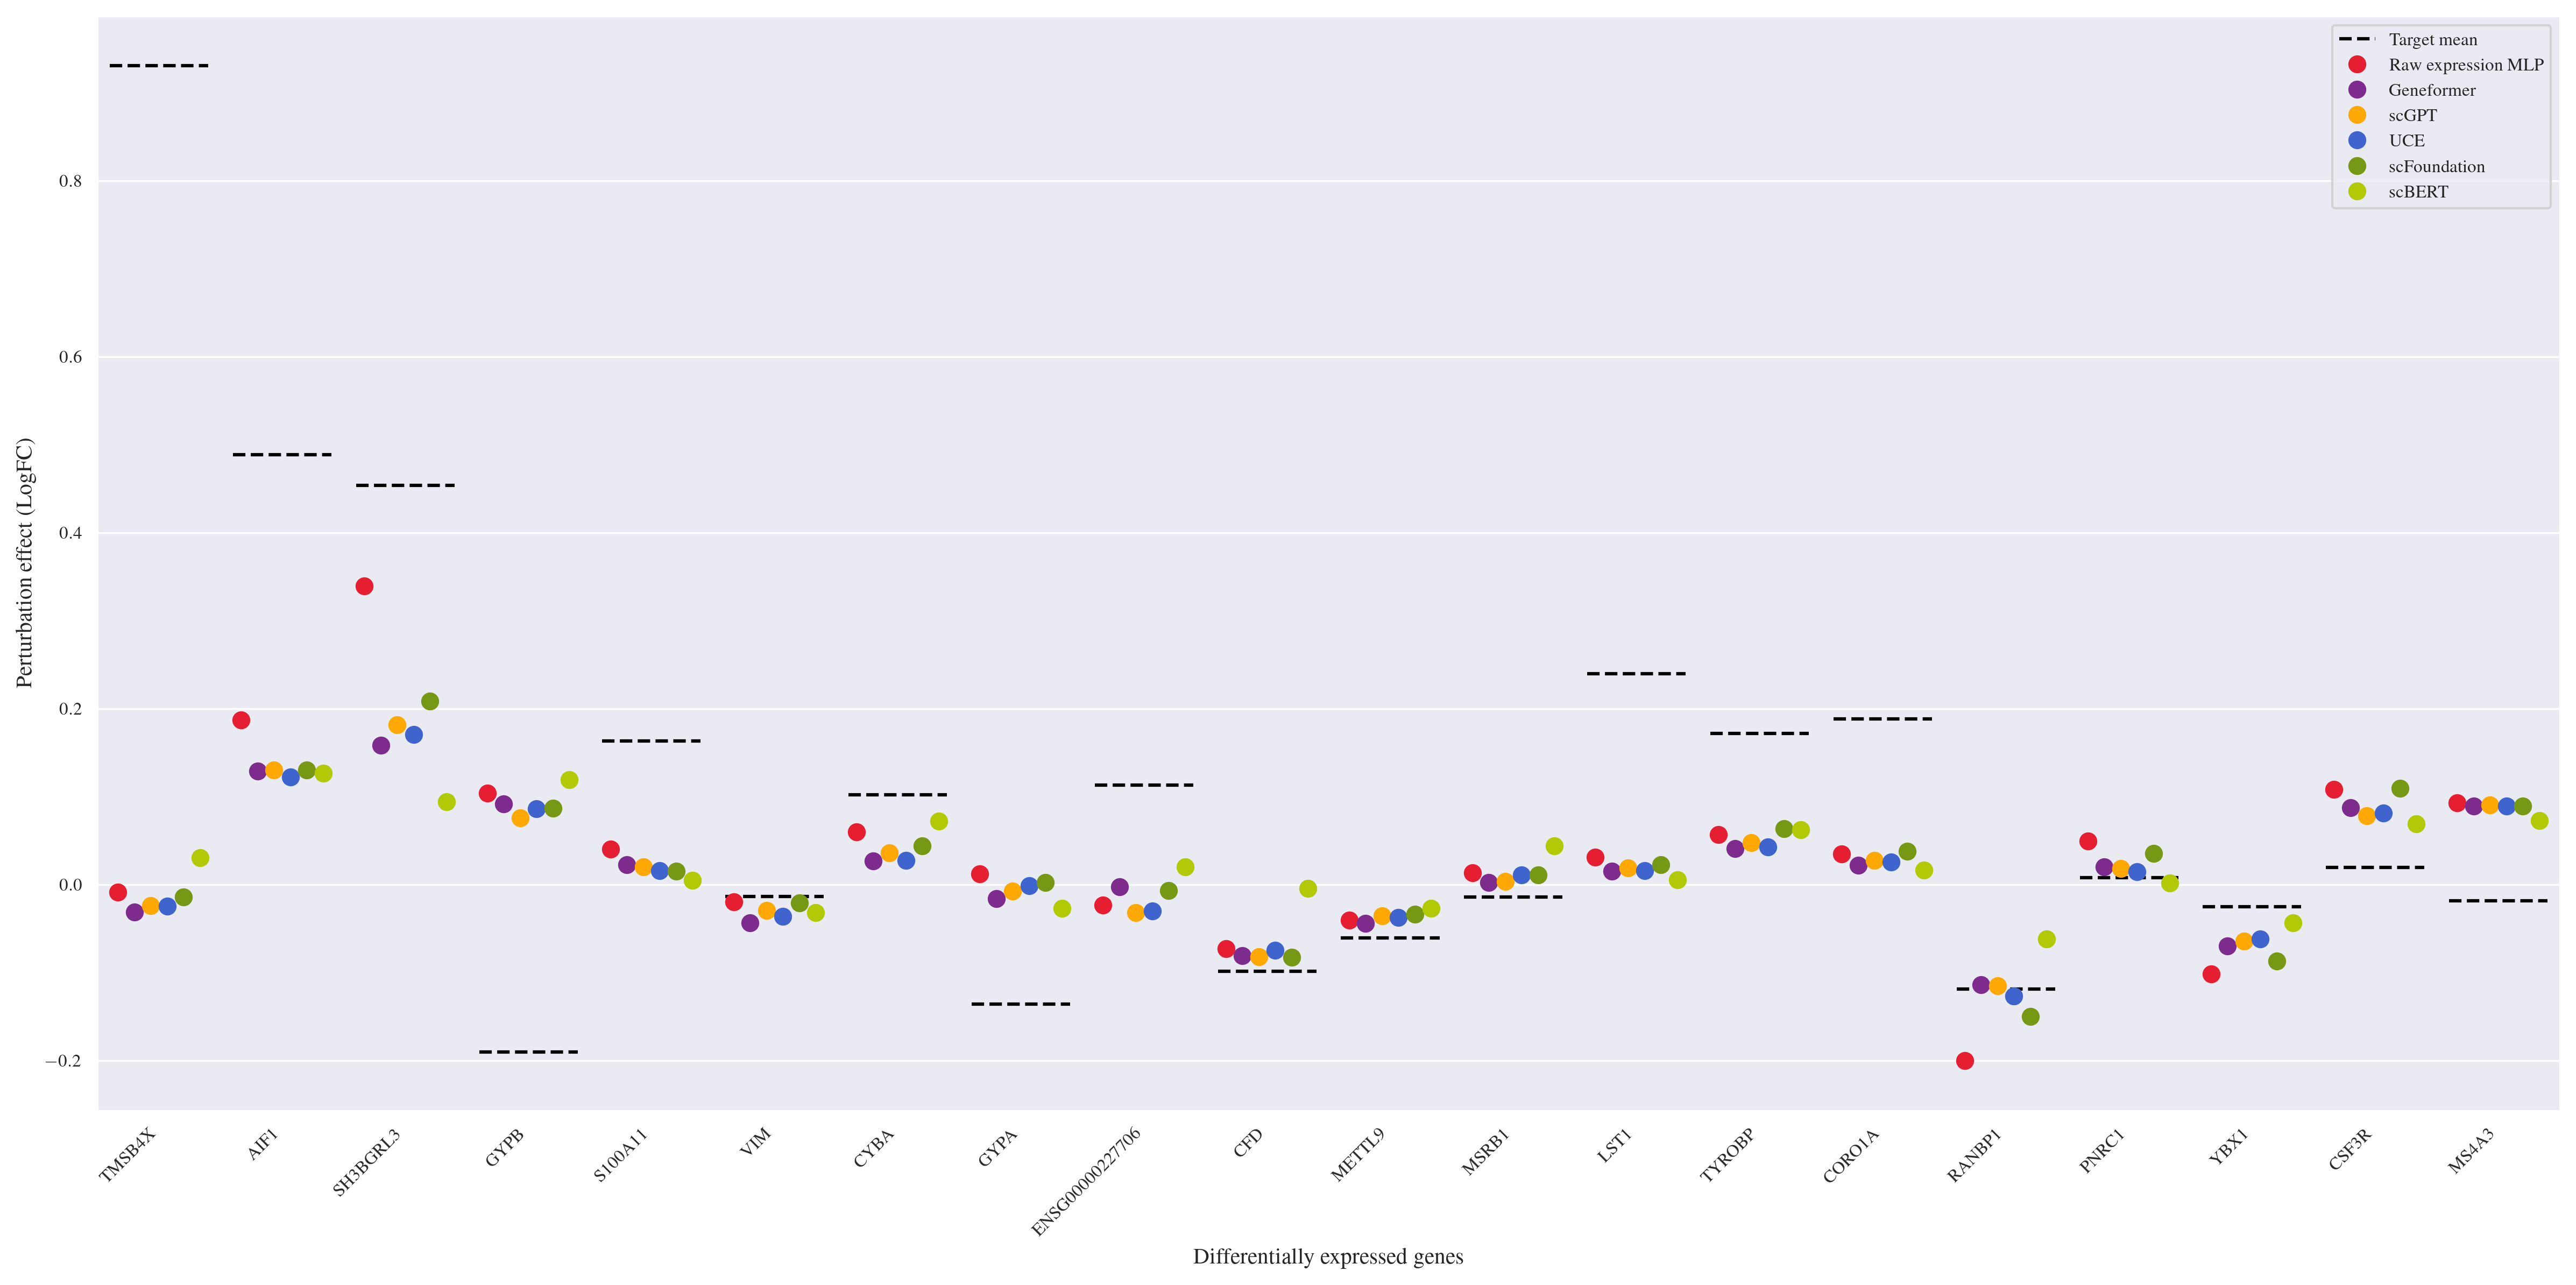

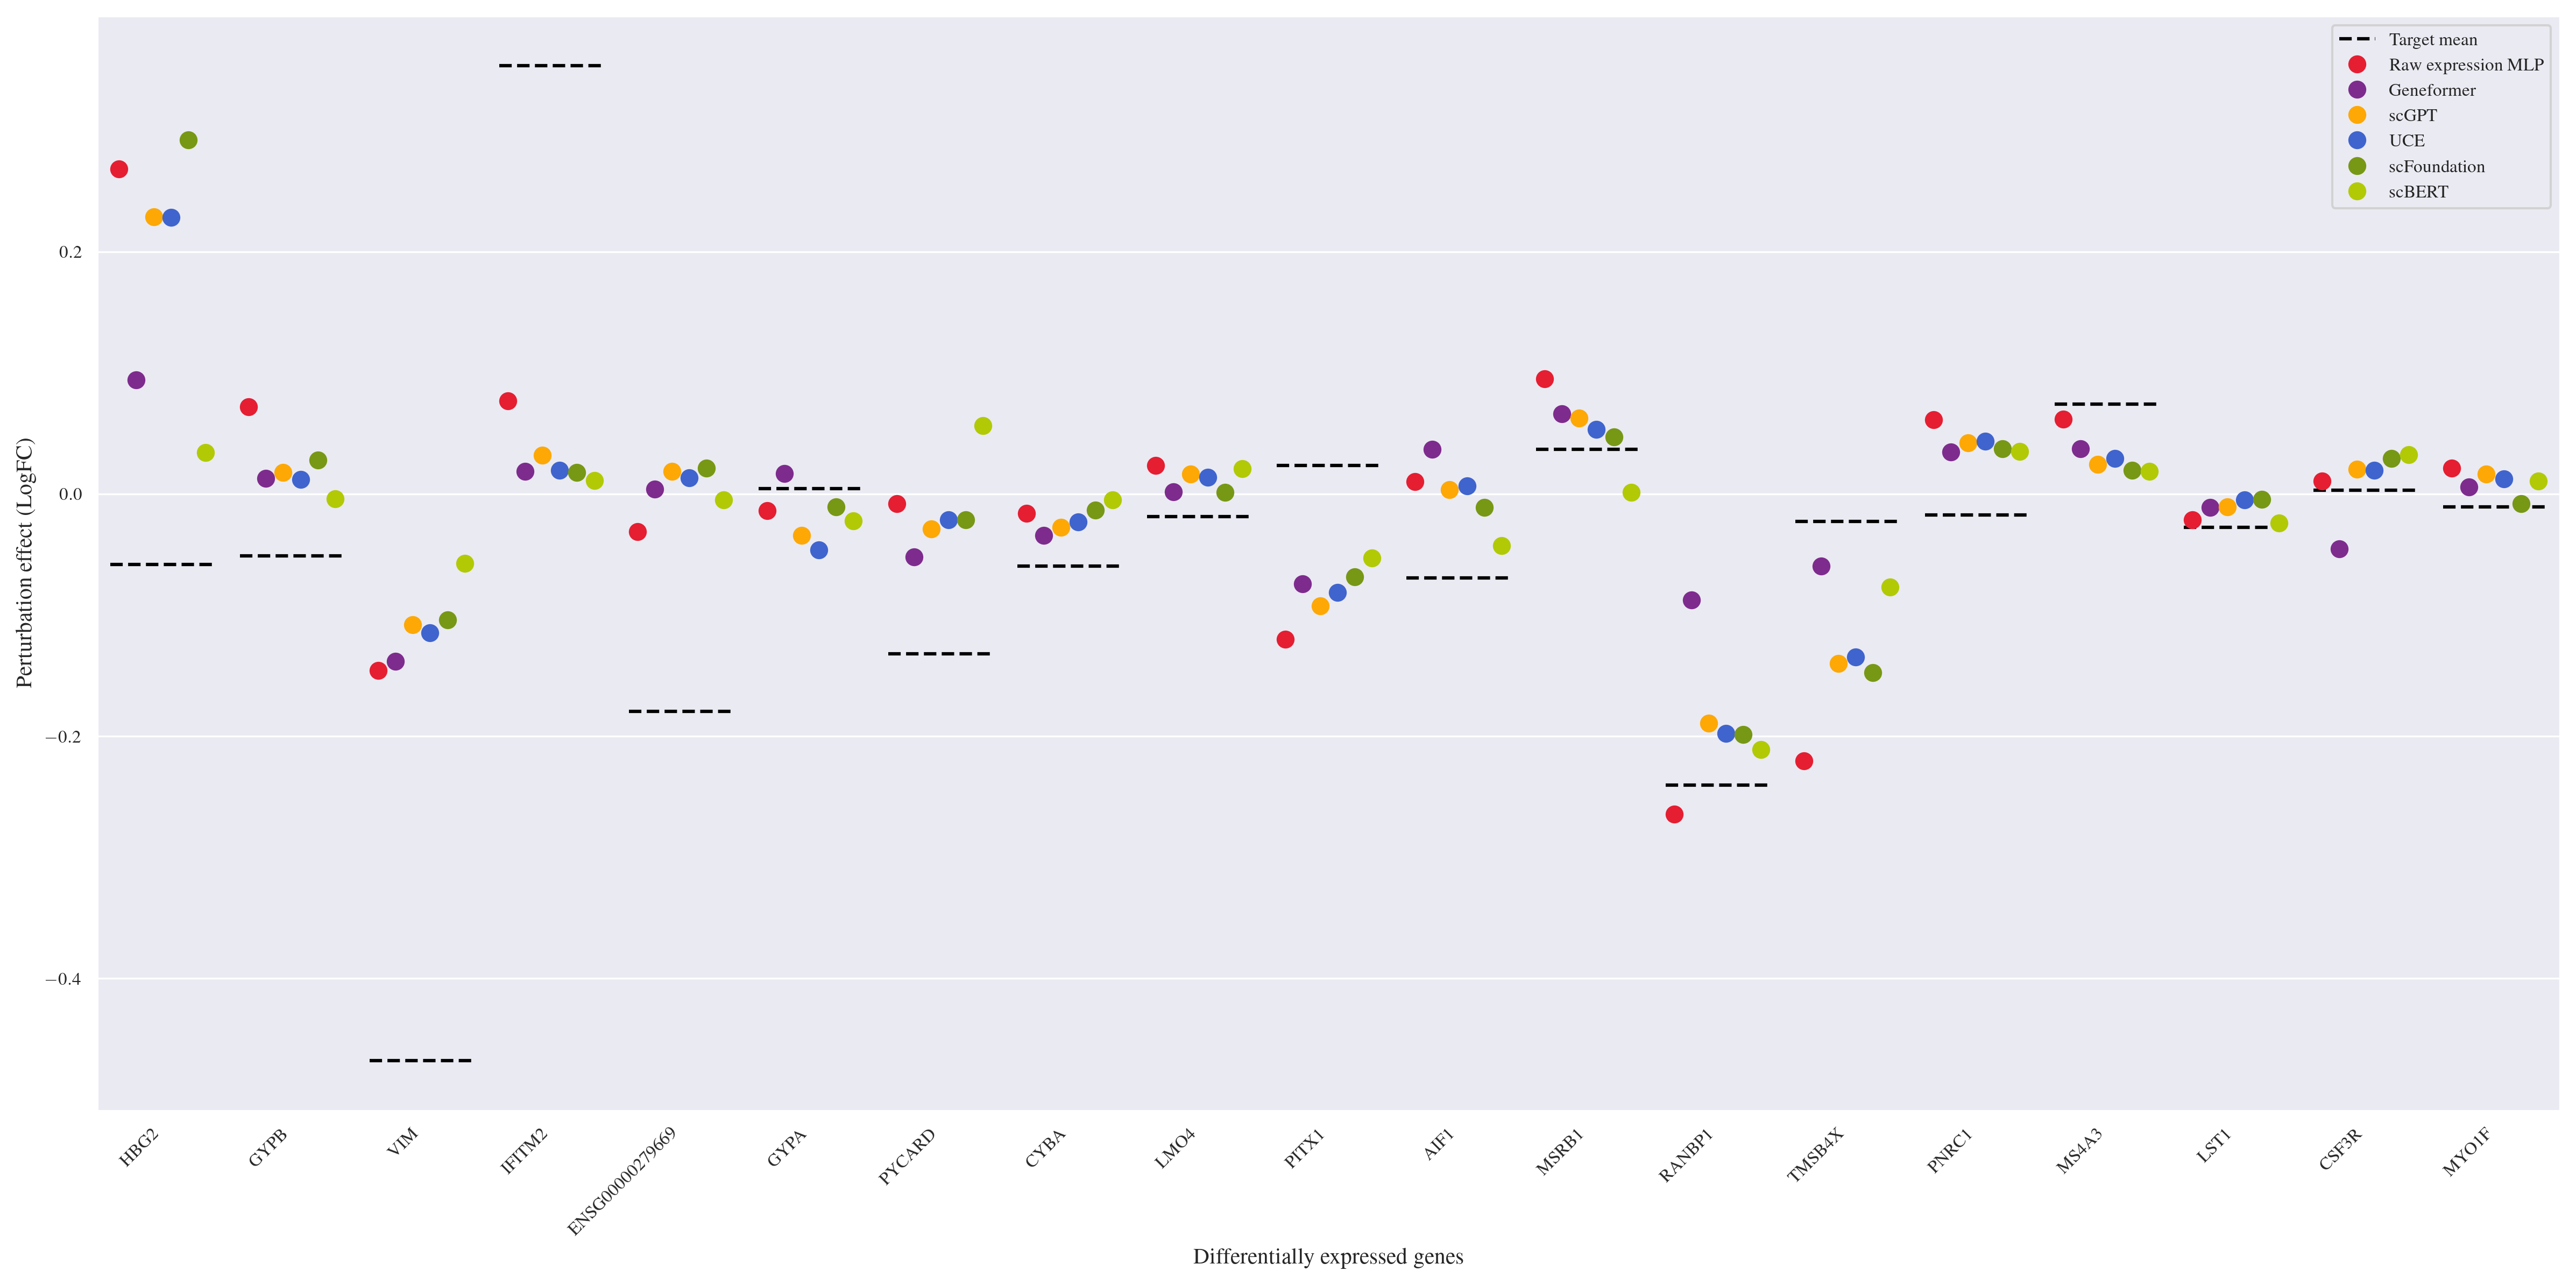

In [142]:
create_swarm_plots(data, deg_dict_symb)

In [27]:
def create_swarm_subplots(data, deg_dict_symb, variance_threshold=0.01, effect_threshold=0.1):
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=300)  # Adjust figure size as needed
    axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

    labels = ['(a)', '(b)', '(c)', '(d)']

    for i, pert in enumerate(data['raw_expression']):
        if i >= 4:  # Only plot the first 4 perturbations
            break

        # Get the differentially expressed genes for this perturbation
        deg_genes = deg_dict_symb.get(pert, [])

        # Extract the target gene expression data
        target = data['raw_expression'][pert]['target']

        # Create a DataFrame for the target
        df_target = pd.DataFrame(target, columns=deg_genes)

        # Calculate variance and absolute mean effect for each gene
        gene_variances = df_target.var()
        gene_effects = df_target.abs().mean()

        # Filter genes based on variance and effect size
        genes_to_keep = (gene_variances > variance_threshold) & (gene_effects > effect_threshold)
        df_target_filtered = df_target.loc[:, genes_to_keep]

        # If no genes pass the filter, skip this plot
        if df_target_filtered.empty:
            print(f"No genes pass the filter for {pert}")
            continue

        # Calculate the mean of the target gene expression data
        target_means = df_target_filtered.mean()

        # Order the genes based on absolute effect size in descending order
        ordered_genes = target_means.sort_values(ascending=False).index.tolist()
        target_means = target_means[ordered_genes]

        # Create a DataFrame to store mean expression for each model
        model_means = pd.DataFrame({'Gene': ordered_genes, 'Target': target_means})

        # Process data for each model
        for model in data:
            pred = data[model][pert]['pred']
            df_model = pd.DataFrame(pred, columns=deg_genes)
            df_model_filtered = df_model[ordered_genes]
            model_means[model] = df_model_filtered.mean()

        # Melt the DataFrame for seaborn
        model_means_melted = model_means.melt(id_vars='Gene', var_name='Model', value_name='Expression')

        # Create the plot in the respective subplot
        ax = axs[i]

        # Plot the target means as dashed lines per gene
        for j, gene in enumerate(ordered_genes):
            ax.plot([j - 0.4, j + 0.4], [target_means[gene]] * 2, 'k--', label='Target mean' if j == 0 else "")

        # Use seaborn's swarmplot to plot the model means
        model_means_melted = model_means_melted[model_means_melted['Model'] != 'Target']
        model_means_melted['Model'] = model_means_melted['Model'].map(model_names)
        palette = {model: model_colors_dict[model] for model in model_means_melted['Model'].unique()}

        sns.swarmplot(data=model_means_melted, x='Gene', y='Expression', hue='Model', dodge=True, size=4,
                      palette=palette, ax=ax)

        # Add vertical lines for each gene
        for j in range(len(ordered_genes)):
            ax.axvline(j + 0.5, color='gray', linestyle='-', linewidth=0.1)

        # Customize the plot
        ax.set_xticks(range(len(ordered_genes)))
        ax.set_xticklabels(ordered_genes, rotation=45, ha='right')
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Adjust x-ticks positioning
        current_ticks = ax.get_xticks()
        current_labels = ax.get_xticklabels()

        # Shift the tick positions 0.25 units to the right
        new_ticks = [tick + 0.25 for tick in current_ticks]

        # Set the new tick positions and labels
        ax.set_xticks(new_ticks)
        ax.set_xticklabels(current_labels, rotation=45, ha='right')
        ax.set_facecolor('white')
        
        for spine in ax.spines.values():
            spine.set_color('black')

        ax.legend().remove()  # Remove individual legends

        handle, label = ax.get_legend_handles_labels()

        # Add perturbation name below the subplot
        if labels[i] == '(a)':
            fig.text(ax.get_position().x0 + ax.get_position().width / 2.2, ax.get_position().y0 - 0.015, f'{labels[i]} {pert}, 0.0',
                     ha='center', va='top', fontsize=10)
        elif labels[i] == '(b)':
            fig.text(ax.get_position().x0 + ax.get_position().width / 1.5, ax.get_position().y0 -0.015, f'{labels[i]} {pert}, 0.7',
                     ha='center', va='top', fontsize=10)
        elif labels[i] == '(c)':
            fig.text(ax.get_position().x0 + ax.get_position().width / 2.2, ax.get_position().y0 - 0.1, f'{labels[i]} {pert}, 0.6',
                        ha='center', va='top', fontsize=10)
        else:
            fig.text(ax.get_position().x0 + ax.get_position().width / 1.5, ax.get_position().y0 - 0.1, f'{labels[i]} {pert}, 0.7',
                        ha='center', va='top', fontsize=10)
    # Create a single legend above all subplots
    lgd = fig.legend(handle, label, loc='upper center', ncol=len(model_names) + 1, bbox_to_anchor=(0.50, 1.05), fontsize=10, facecolor='white')

    y_ax = fig.text(-0.01, 0.5, 'Perturbation effect (LogFC)', va='center', rotation='vertical', fontsize=12)
    x_ax = fig.text(0.4, -0.05, 'Differentially expressed genes', va='center', rotation='horizontal', fontsize=12)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.6) 
    plt.savefig("paper_figs/swarmplot_grid.pdf", bbox_extra_artists=(lgd, y_ax, x_ax,), bbox_inches='tight', dpi=300)
    
    plt.show()

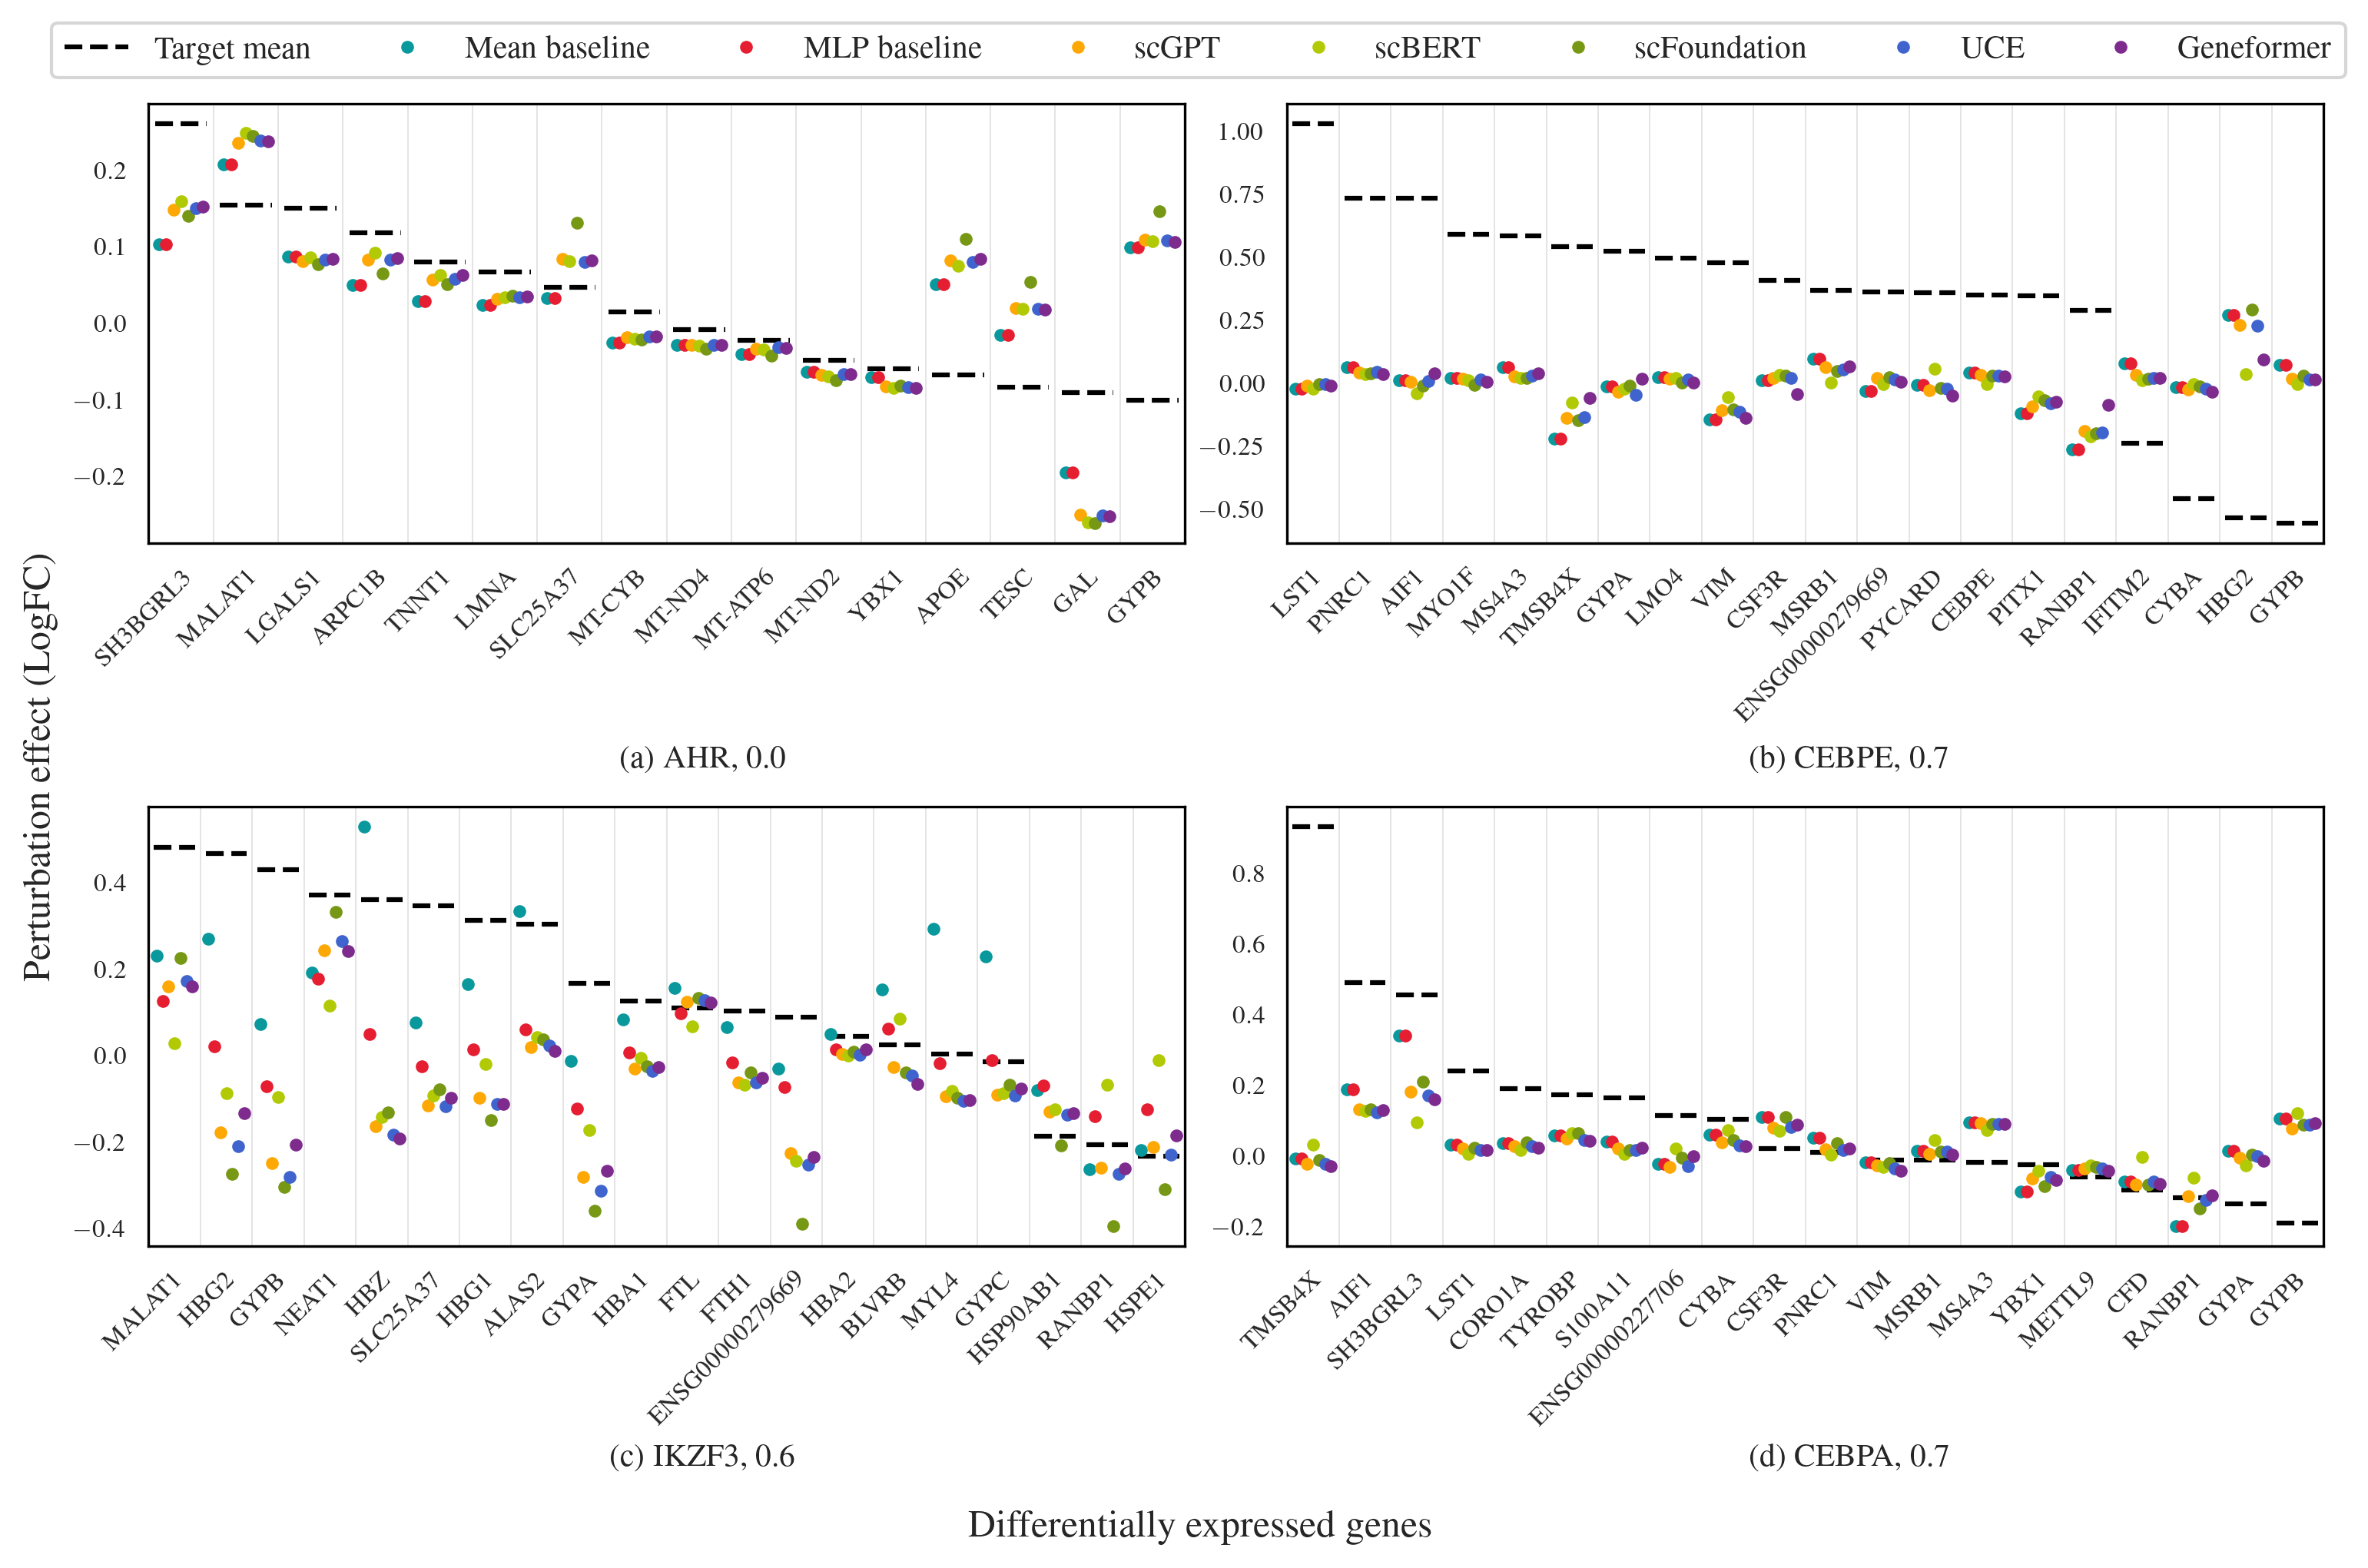

In [28]:
create_swarm_subplots(data, deg_dict_symb)

## Characterise top part of the distribution with 95th percentile of effect sizes

In [174]:
# calculate 90th percentile of the target means for all the perts 
percentile_90 = {}
for i, pert in enumerate(data['raw_expression']):
    # Get the differentially expressed genes for this perturbation
    deg_genes = deg_dict_symb.get(pert, [])
    variance_threshold=0.01 
    effect_threshold=0.1

    # Extract the target gene expression data
    target = data['raw_expression'][pert]['target']

    # Create a DataFrame for the target
    df_target = pd.DataFrame(target, columns=deg_genes)

    # Calculate variance and absolute mean effect for each gene
    gene_variances = df_target.var()
    gene_effects = df_target.abs().mean()

    # Filter genes based on variance and effect size
    genes_to_keep = (gene_variances > variance_threshold) & (gene_effects > effect_threshold)
    df_target_filtered = df_target.loc[:, genes_to_keep]

    # If no genes pass the filter, skip this plot
    if df_target_filtered.empty:
        print(f"No genes pass the filter for {pert}")
        continue

    # Calculate the mean of the target gene expression data
    target_means = df_target_filtered.mean()

    # Order the genes based on absolute effect size in descending order
    ordered_genes = target_means.sort_values(ascending=False).index.tolist()
    target_means = target_means[ordered_genes]
    abs_means = target_means.abs()
    percentile_95[pert] = np.percentile(abs_means, 95)
    
percentile_95

{'AHR': 0.18053261563181877,
 'IKZF3': 1.4171086430549624,
 'CEBPA': 0.5105715930461887,
 'CEBPE': 0.3650177180767057}